# Исследование для стартапа по продаже продуктов питания

## Введение

В данной работе предстоит разобраться, как ведут себя пользователи мобильного приложения стартапа по продаже продуктов питания.

В исследовании предстоит работа с логом пользователей. Каждая запись в логе — это действие пользователя, или событие. Таблица содержит следующие данные:

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Для проведения анализа необходимо выполнить следующие этапы:

- выполнить предобработку данных: установить корректный тип данных и стиль оформления названий столбцов, провести проверку на пропуски и дубликаты;
- добавить новые столбцы в исходный датафрейм: с датой и временем, а также отдельный столбец дат;
- выполнить исследование и проверку данных;
- построить и изучить воронку событий;
- исследовать результаты A/A/B теста.

Дизайнеры захотели поменять шрифты во всём приложении, есть опасения, что пользователям будет непривычно. Необходимо принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нужно выяснить, какой шрифт лучше.

Приступим к анализу:

### Загрузка данных и их подготовка к анализу

In [5]:
# импорт библиотек

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mth
import plotly.express as px
import warnings
warnings.simplefilter("ignore")

Запишем данные от компании в датафрейм `logs` и подготовим их к анализу.

In [7]:
# считываем данные в датафрейм

logs = pd.read_csv('C:/Users/Кристина/Desktop/Шпаргалки/Проекты/logs_exp.csv', sep='\t')

In [8]:
# создадим функцию для первичной обработки данных (вывод общей информации)

def research(data):
    display(data.head(10))                                       # вывод первых строк датафрейма
    print('*' * 50)                                              # разделитель
    data.info()                                                  # вывод общей информации о датафрейме
    print('*' * 50, '\n\033[1m Количество полных дублей: \033[0m', 
            data.duplicated().sum())                             # проверка на полные дубликаты
    print('*' * 50)
    display(data.describe())                                     # описание распределения численных значений
    print('*' * 50)
    
    for x in data.columns:
        display(data[x].value_counts().to_frame())               # распределение значений в каждом столбце

In [9]:
research(logs)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
************************************************** 
 Количество полных дублей:  413
**************************************************


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


**************************************************


,count
EventName,
MainScreenAppear,119205
OffersScreenAppear,46825
CartScreenAppear,42731
PaymentScreenSuccessful,34313
Tutorial,1052


,count
DeviceIDHash,
6304868067479728361,2308
197027893265565660,2003
4623191541214045580,1771
6932517045703054087,1448
1754140665440434215,1222
...,...
1473604074272762258,1
4038665841336196550,1
6471198426894625455,1


,count
EventTimestamp,
1564670435,9
1564935799,9
1565017227,8
1565176721,8
1564911846,8
...,...
1564837824,1
1564837843,1
1564837844,1


,count
ExpId,
248,85747
246,80304
247,78075


Таблица с событиями и действиями пользователей имеет 244 126 строк и 4 столбца. Столбцы необходимо привести к корректному стилю наименований. Ниже сделаем это:

In [11]:
logs = logs.rename(columns={'EventName': 'event_name', 
                     'DeviceIDHash': 'user_id', 
                     'EventTimestamp':'event_timestamp',
                     'ExpId':'exp_id'})

In [12]:
logs.columns # проверка

Index(['event_name', 'user_id', 'event_timestamp', 'exp_id'], dtype='object')

В рассматриваемой таблице нет пропусков, однако есть полные дубликаты, удалим их:

In [14]:
logs = logs.drop_duplicates().reset_index(drop=True)

In [15]:
logs.duplicated().sum() # проверка дубликатов

0

Далее приведём столбцы к корректному типу данных. В столбце `event_timestamp` данные даты и времени представлены в формате unix time. Так как далее по работе нам предстоит добавить новые столбцы к датафрейму - с датой и временем и отдельно с датой, то в самом столбце `event_timestamp` тип данных менять не будем.

Заменить тип данных можно в столбцах `event_name` и `exp_id` на категориальный для сокращения использования памяти, так как в данных столбцах небольшое количество уникальных значений:

In [17]:
logs = logs.astype({'event_name': 'category', 'exp_id': 'category'})

In [18]:
logs.dtypes # проверка

event_name         category
user_id               int64
event_timestamp       int64
exp_id             category
dtype: object

Помимо этого, датафрейм нужно проверить на корректное разбиение пользователей по группам. Проверим нет ли такого, что один пользователь относится к нескольким группам одновременно:

In [20]:
logs.groupby('user_id').agg({'exp_id':'nunique'}).reset_index().query('exp_id>1').count()

user_id    0
exp_id     0
dtype: int64

В датафрейме нет пользователей, которые бы принадлежали к нескольким группам одновременно.

Далее добавим столбцы с датой и временем и отдельно с датой к нашему датафрейму:

In [23]:
logs['datetime'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs['date'] = pd.to_datetime(logs['event_timestamp'], unit='s').dt.date

In [24]:
logs.head(5) # проверка

,event_name,user_id,event_timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


**Вывод**

- данные, которые предстоит исследовать, содержат информацию о событиях и действиях пользователей и записаны в датафрейм `logs`;
- были изменены названия столбцев в соответствии с правильным стилем, удалены полные дубликаты;
- изменены типы данных в столбцах `event_name` и `exp_id` на категориальный для сокращения использования памяти, так как в данных столбцах небольшое количество уникальных значений;
- пропусков в данных не выявлено;
- добавлено 2 столбца: `datetime` с датой и временем события и `date` только с датой события.

### Исследование данных

В данном пункте исследования изучим и проверим данные.

Вызовем ещё раз функцию для вывода общей информации по датафрейму и ответим на некоторые общие вопросы, опираясь на неё:

In [29]:
research(logs)

,event_name,user_id,event_timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
5,CartScreenAppear,6217807653094995999,1564055323,248,2019-07-25 11:48:43,2019-07-25
6,OffersScreenAppear,8351860793733343758,1564066242,246,2019-07-25 14:50:42,2019-07-25
7,MainScreenAppear,5682100281902512875,1564085677,246,2019-07-25 20:14:37,2019-07-25
8,MainScreenAppear,1850981295691852772,1564086702,247,2019-07-25 20:31:42,2019-07-25
9,MainScreenAppear,5407636962369102641,1564112112,246,2019-07-26 03:35:12,2019-07-26


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  category      
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  category      
 4   datetime         243713 non-null  datetime64[ns]
 5   date             243713 non-null  object        
dtypes: category(2), datetime64[ns](1), int64(2), object(1)
memory usage: 7.9+ MB
************************************************** 
 Количество полных дублей:  0
**************************************************


,user_id,event_timestamp,datetime
count,2.437130e+05,2.437130e+05,243713
mean,4.627963e+18,1.564914e+09,2019-08-04 10:19:17.987665920
min,6.888747e+15,1.564030e+09,2019-07-25 04:43:36
25%,2.372212e+18,1.564757e+09,2019-08-02 14:36:45
50%,4.623192e+18,1.564919e+09,2019-08-04 11:51:00
75%,6.932517e+18,1.565075e+09,2019-08-06 06:56:24
max,9.222603e+18,1.565213e+09,2019-08-07 21:15:17
std,2.642723e+18,1.771388e+05,NaN


**************************************************


,count
event_name,
MainScreenAppear,119101
OffersScreenAppear,46808
CartScreenAppear,42668
PaymentScreenSuccessful,34118
Tutorial,1018


,count
user_id,
6304868067479728361,2307
197027893265565660,1998
4623191541214045580,1768
6932517045703054087,1439
1754140665440434215,1221
...,...
6888746892508752,1
6671109879025379318,1
1223708690315846789,1


,count
event_timestamp,
1564670435,9
1564935799,9
1565176721,8
1565017227,8
1564911846,8
...,...
1564837684,1
1564837689,1
1564837690,1


,count
exp_id,
248,85582
246,80181
247,77950


,count
datetime,
2019-08-01 14:40:35,9
2019-08-04 16:23:19,9
2019-08-07 11:18:41,8
2019-08-05 15:00:27,8
2019-08-04 09:44:06,8
...,...
2019-08-03 13:08:04,1
2019-08-03 13:08:09,1
2019-08-03 13:08:10,1


,count
date,
2019-08-01,36141
2019-08-05,36058
2019-08-06,35788
2019-08-02,35554
2019-08-03,33282
2019-08-04,32968
2019-08-07,31096
2019-07-31,2030
2019-07-30,412


Всего в логе возможно пять событий:
1. *MainScreenAppear* - появление главной страницы;
2. *OffersScreenAppear* - появление страницы с предложениями (товарами);
3. *CartScreenAppear* - появление страницы с корзиной;
4. *PaymentScreenSuccessful* - появление страницы об успешной оплате;
5. *Tutorial* - руководство пользователя.

В логе всего представлено 7551 различных пользователей.

Далее проверим сколько в среднем событий приходится на  одного пользователя:

In [31]:
logs.groupby('user_id').agg({'event_name':'count'}).mean()

event_name    32.275593
dtype: float64

В среднем на одного пользователя приходится около 32 событий за рассматриваемый период.

Проверим данными за какой период мы располагаем, найдя минимальную и максимальную даты по столбцу `date`:

In [34]:
logs.agg({'date':['min', 'max']})

,date
min,2019-07-25
max,2019-08-07


Представлена информация с 25 июля 2019 года по 7 августа 2019 года, то есть за 2 недели.

Изучим, как меняется количество данных. Для этого построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп:

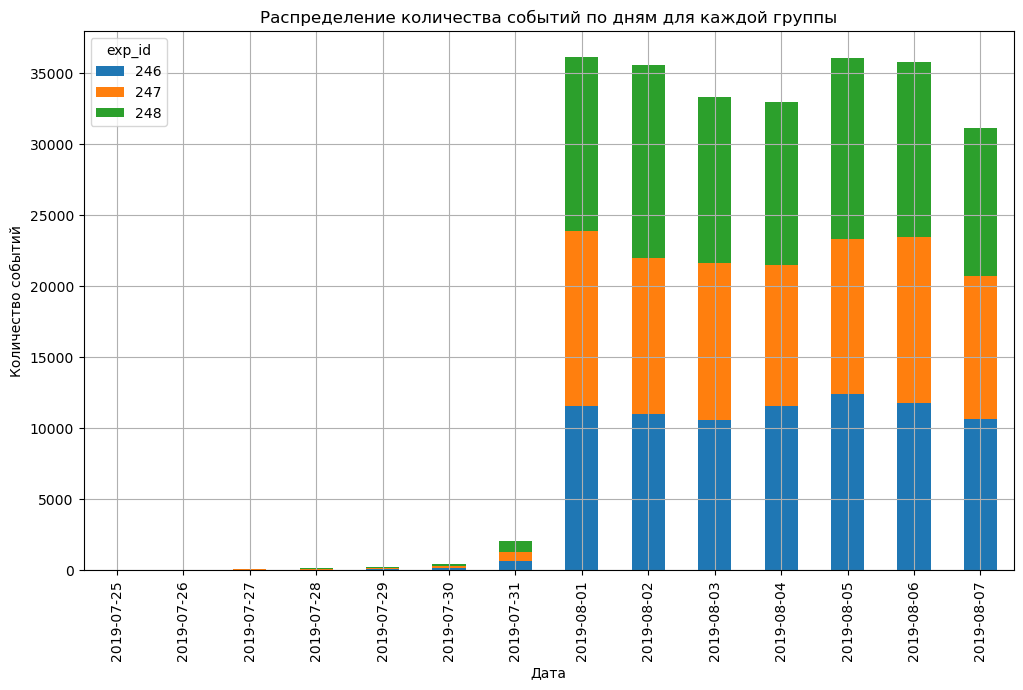

In [37]:
logs.pivot_table(index='date', columns = 'exp_id', values='event_name', aggfunc='count').plot(
    kind='bar',
    title='Распределение количества событий по дням для каждой группы',
    figsize=(12,7), grid=True, stacked=True)

plt.xlabel('Дата')
plt.ylabel('Количество событий');

Таким образом, видим что количество учтённых событий до 1 августа 2019 намного меньше, чем после этой даты. Значит, почему-то изначально тест учитывал не всех пользователей и данные до августа неполные. Следует исключить их из дальнейшего анализа во избежание некорректной интерпретации результатов.

In [39]:
logs_filtered = logs[logs['date'] >= datetime.strptime("2019-08-01", "%Y-%m-%d").date()]

Проверим данные, построив новый график:

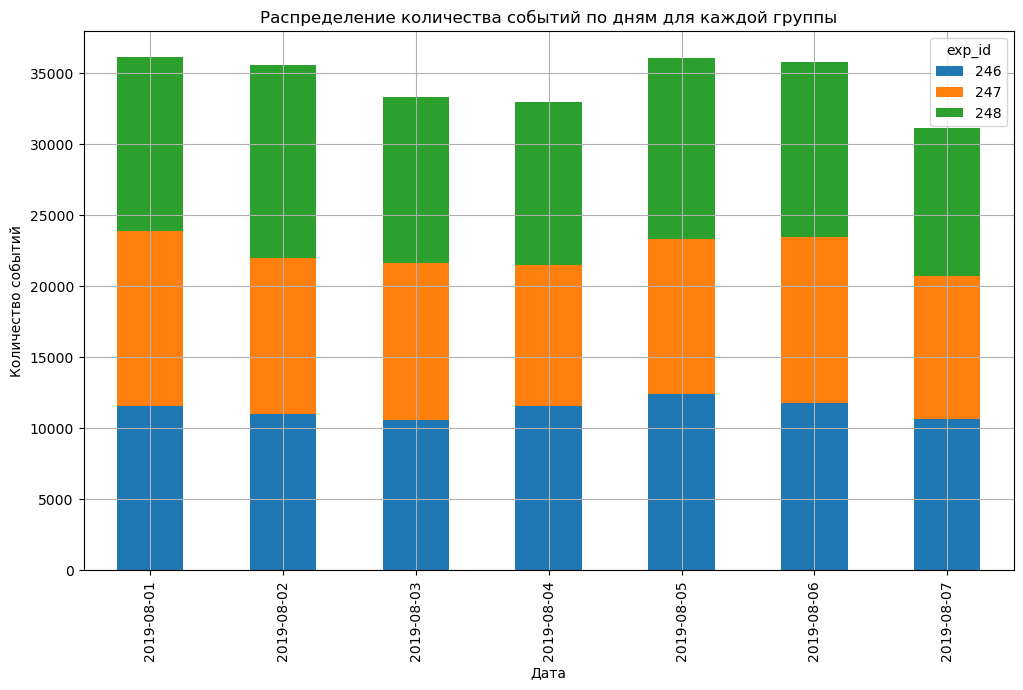

In [41]:
logs_filtered.pivot_table(index='date', columns = 'exp_id', values='event_name', aggfunc='count').plot(
    kind='bar',
    title='Распределение количества событий по дням для каждой группы',
    figsize=(12,7), grid=True, stacked=True)

plt.xlabel('Дата')
plt.ylabel('Количество событий');

Теперь данные выглядят полно и рассматриваемый период сократился до 1 недели. В наших данных всё так же присутствует 3 группы пользователей. Проверим скольких пользователей и событий мы потеряли, исключив более ранний временной период:

In [43]:
# абсолютное значение в разнице пользователей

logs['user_id'].nunique()-logs_filtered['user_id'].nunique()

17

In [44]:
# относительное значение в разнице пользователей

round((logs_filtered['user_id'].nunique()/logs['user_id'].nunique()-1)*100, 3)

-0.225

In [45]:
# абсолютное значение в разнице событий

logs['event_name'].count()-logs_filtered['event_name'].count()

2826

In [46]:
# относительное значение в разнице событий

round((logs_filtered['event_name'].count()/logs['event_name'].count()-1)*100, 3)

-1.16

То есть мы лишились 17 пользователей, что составило около 0,23% от первоначальных данных и 2826 или 1,16% событий. В целом, это незначительная потеря данных. 

**Вывод**

В ходе исследования таблицы `logs` мы проверили, что всего в логе возможно 5 видов событий, при этом в среднем на одного пользователя приходится около 32 событий.

В данных была информация за 2-недельный период, однако построив график распределения количества событий по дням для каждой группы, выявлено, что данные до 1 августа 2019 неполные и учитывать их в дальнейшем анализе нецелесообразно. В связи с этим, мы отфильтровали для анализа только данные с 1 по 7 августа 2019 года, тем самым, сократив анализируемый период времени до 1-й недели.

Отфильтровав данные, мы отбросили около 0,23% пользователей и 1,16% событий.

### Воронка событий

Мы уже изучили, какие события есть в логах и как часто они встречаются, но выведим данную информацию ещё раз, отсортировав события по частоте:

In [51]:
logs_filtered['event_name'].value_counts()

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64

Далее посчитаем, сколько пользователей совершали каждое из этих событий. Запишем данные в новую таблицу `funnel`. Отсортируем события по числу пользователей:

In [53]:
funnel = (
    logs_filtered.pivot_table(index='event_name', values='user_id', aggfunc='nunique')
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)

funnel.columns = ['event_name', 'user_unique']
funnel

,event_name,user_unique
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Посчитаем долю пользователей, которые хоть раз совершали событие:

In [55]:
funnel['proportion'] = (funnel['user_unique']/logs_filtered['user_id'].nunique()).map(lambda x: '{:.2f}'.format(x))
funnel

,event_name,user_unique,proportion
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


Так, логично предположить, что воронка событий для пользователей имеет следующий вид и порядок:

1. MainScreenAppear - появление главной страницы;
2. OffersScreenAppear - появление страницы с предложениями (товарами);
3. CartScreenAppear - появление страницы с корзиной;
4. PaymentScreenSuccessful - появление страницы об успешной оплате.

Как видно, не все этапы мы отнесли к последовательной событийной воронке. Обучение (*Tutorial*) пользователи могут пропускать, из-за этого данное событие имеет наименьшую долю использования пользователями. Поэтому при дальнейшем расчёте конверсии из одного шага в другой не будем учитывать *Tutorial*:

In [57]:
funnel = funnel.query('event_name != "Tutorial"')

Визуализируем полученную событийную воронку:

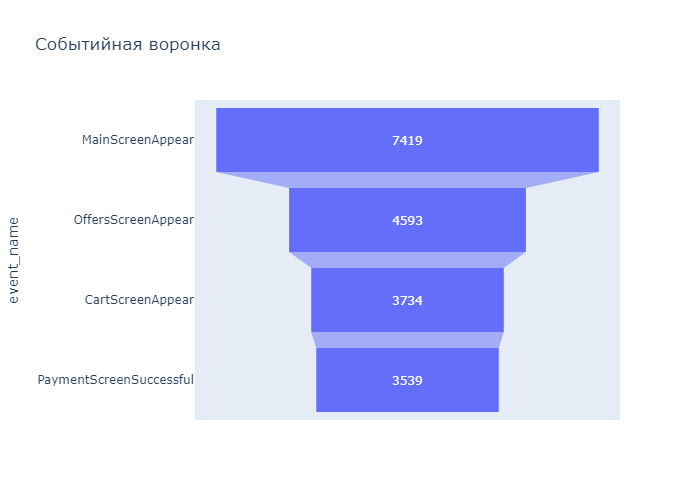

In [166]:
fig = px.funnel(
    funnel,
    y='event_name',
    x='user_unique',
    title="Событийная воронка")
fig.show('png')

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем): 

In [61]:
funnel = funnel.reset_index(drop=True)

In [62]:
for i in range(len(funnel)-1):
    funnel.loc[i+1, 'conversion'] = round(funnel.loc[i+1,'user_unique']/funnel.loc[i,'user_unique'], 2)
funnel

,event_name,user_unique,proportion,conversion
0,MainScreenAppear,7419,0.98,NaN
1,OffersScreenAppear,4593,0.61,0.62
2,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95


Судя по полученной воронке и дополнительно рассчитанным столбцам, больше всего пользователей мы теряем сразу после шага `MainScreenAppear`, 38% пользователей не доходят до второго этапа воронки `OffersScreenAppear`.

При этом 47% от всех пользователей доходит от начала и до последнего шага воронки - успешной оплаты заказа.

**Вывод**

На третьем этапе исследования была проанализирована частота всех возможных событий в логе. Посчитано, сколько пользователей совершали каждое из 5 представленных событий.

Мы предположили, что воронка для пользователей имеет следующий порядок:

1. MainScreenAppear - появление главной страницы;
2. OffersScreenAppear - появление страницы с предложениями (товарами);
3. CartScreenAppear - появление страницы с корзиной;
4. PaymentScreenSuccessful - появление страницы об успешной оплате.

Не все этапы отнесли к последовательной событийной воронке - обучение (Tutorial) пользователи могут пропускать, из-за этого данное событие имеет наименьшую долю использования пользователями.

По воронке событий посчитана доля пользователей, которая проходит на каждый следующий шаг воронки (от числа пользователей на предыдущем) - конверсия из шага в шаг.

Получен вывод о том, что больше всего пользователей мы теряем сразу после шага `MainScreenAppear`: 38% пользователей не доходят до второго этапа воронки (`OffersScreenAppear`), вероятно, нужно лучше прорабатывать механику приложения, чтобы увеличить конверсию в данный шаг. При этом 47% от всех пользователей доходит от начала и до последнего шага воронки - успешной оплаты заказа.

### Результаты A/B теста

Для начала анализа результатов эксперимента оценим сколько пользователей находится в каждой экспериментальной группе:

In [67]:
logs_filtered.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Проверим долю пользователей в каждой группе от общего числа пользователей:

In [69]:
round(logs_filtered.groupby('exp_id')['user_id'].nunique()/logs_filtered['user_id'].nunique(),3)

exp_id
246    0.330
247    0.334
248    0.337
Name: user_id, dtype: float64

Доли незначительно отличаются друг от друга, однако нужно проверить находят ли статистические критерии разницу между контрольными выборками 246 и 247. Для этого мы должны проверить гипотезы о равенстве долей в разрезе каждого события:

#### Функция для проверки гипотез о равенстве долей

Создадим функцию `z-test`, которая позволит сравнивать выборки по разным событиям для разных групп:

In [73]:
def z_test(users_event_group1, users_event_group2, users_group1, users_group2, alpha):
    
    # пропорция пользователей, совершивших событие в первой группе:
    p1 = users_event_group1/users_group1
    
    # пропорция пользователей, совершивших событие во второй группе:
    p2 = users_event_group2/users_group2
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (users_event_group1 + users_event_group2) / (users_group1 + users_group2)
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_group1 + 1/users_group2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

#### Проверка гипотезы о равенстве долей контрольных групп

Далее вызовем функцию поочередно для каждого события воронки групп 246 и 247:

Примем исходный уровень значимости равный 5% и применим метод для коррекции уровеня значимости:

In [77]:
alpha_original = 0.05 # исходный уровень значимости

In [78]:
# рассчитываем поправку Холма с помощью функции

def holm_correction(m, alpha):
    result = []
    for i in range(m): # получаем номер текущей проверки гипотезы и считаем коррекцию 
        result += [alpha / (m - i)]
    return result

In [79]:
result = holm_correction(16, alpha_original)

In [80]:
# проверка гипотезы о равенстве долей по событию MainScreenAppear:

n = 0 # счетчик для нужного уровеня значимости

z_test(
    logs_filtered.query('exp_id == 246 & event_name == "MainScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247 & event_name == "MainScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 246')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247')['user_id'].nunique(),
    result[n]
)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [81]:
# проверка гипотезы о равенстве долей по событию OffersScreenAppear:

n += 1

z_test(
    logs_filtered.query('exp_id == 246 & event_name == "OffersScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247 & event_name == "OffersScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 246')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247')['user_id'].nunique(),
    result[n]
)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [82]:
# проверка гипотезы о равенстве долей по событию CartScreenAppear:
n += 1

z_test(
    logs_filtered.query('exp_id == 246 & event_name == "CartScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247 & event_name == "CartScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 246')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247')['user_id'].nunique(),
    result[n]
)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [83]:
# проверка гипотезы о равенстве долей по событию PaymentScreenSuccessful:
n += 1

z_test(
    logs_filtered.query('exp_id == 246 & event_name == "PaymentScreenSuccessful"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247 & event_name == "PaymentScreenSuccessful"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 246')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247')['user_id'].nunique(),
    result[n]
)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Таким образом, проверив гипотезу о равенстве долей пользователей по каждому событию групп 246 и 247, мы приходим к выводу, что нет оснований считать доли разными, значит, разбиение рассматриваемых групп работает корректно.

#### Проверка гипотезы о равенстве долей каждой из контрольных групп с экспериментальной

Далее проверим тот же тест с эксперементальной группой с изменённым шрифтом (248). Сравним результаты с каждой из контрольных групп в отдельности по каждому событию:

In [87]:
# проверка гипотезы о равенстве долей групп 246 и 248 по событию MainScreenAppear:
n += 1

z_test(
    logs_filtered.query('exp_id == 246 & event_name == "MainScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "MainScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 246')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [88]:
# проверка гипотезы о равенстве долей групп 246 и 248 по событию OffersScreenAppear:
n += 1

z_test(
    logs_filtered.query('exp_id == 246 & event_name == "OffersScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "OffersScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 246')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [89]:
# проверка гипотезы о равенстве долей групп 246 и 248 по событию CartScreenAppear:
n += 1

z_test(
    logs_filtered.query('exp_id == 246 & event_name == "CartScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "CartScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 246')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [90]:
# проверка гипотезы о равенстве долей групп 246 и 248 по событию PaymentScreenSuccessful:
n += 1

z_test(
    logs_filtered.query('exp_id == 246 & event_name == "PaymentScreenSuccessful"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "PaymentScreenSuccessful"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 246')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверив гипотезу о равенстве долей по каждому событию групп 246 и 248, получаем результат о том, что нет оснований считать доли разными, значит, нет оснований полагать, что новая версия шрифта как-либо влияет на поведение пользователей.

In [92]:
# проверка гипотезы о равенстве долей групп 247 и 248 по событию MainScreenAppear:
n += 1

z_test(
    logs_filtered.query('exp_id == 247 & event_name == "MainScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "MainScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [93]:
# проверка гипотезы о равенстве долей групп 247 и 248 по событию OffersScreenAppear:
n += 1

z_test(
    logs_filtered.query('exp_id == 247 & event_name == "OffersScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "OffersScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [94]:
# проверка гипотезы о равенстве долей групп 247 и 248 по событию CartScreenAppear:
n += 1

z_test(
    logs_filtered.query('exp_id == 247 & event_name == "CartScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "CartScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [95]:
# проверка гипотезы о равенстве долей групп 247 и 248 по событию PaymentScreenSuccessful:
n += 1

z_test(
    logs_filtered.query('exp_id == 247 & event_name == "PaymentScreenSuccessful"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "PaymentScreenSuccessful"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 247')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверив гипотезу о равенстве долей по каждому событию групп 247 и 248, аналогично предыдущим результатам, получаем итог: нет оснований считать доли разными, значит, нет оснований полагать, что новая версия шрифта как-либо влияет на поведение пользователей.

#### Проверка гипотезы о равенстве долей объединенной контрольной группы с экспериментальной

Итоговой проверкой сравним результаты группы 248 с объединённой контрольной группой (246 + 247):

In [99]:
# проверка гипотезы о равенстве долей групп 246+247 и 248 по событию MainScreenAppear:
n += 1

z_test(
    logs_filtered.query('exp_id != 248 & event_name == "MainScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "MainScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id != 248')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [100]:
# проверка гипотезы о равенстве долей групп 246+247 и 248 по событию OffersScreenAppear:
n += 1

z_test(
    logs_filtered.query('exp_id != 248 & event_name == "OffersScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "OffersScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id != 248')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [101]:
# проверка гипотезы о равенстве долей групп 246+247 и 248 по событию CartScreenAppear:
n += 1

z_test(
    logs_filtered.query('exp_id != 248 & event_name == "CartScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "CartScreenAppear"')['user_id'].nunique(),
    logs_filtered.query('exp_id != 248')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [102]:
# проверка гипотезы о равенстве долей групп 246+247 и 248 по событию PaymentScreenSuccessful:
n += 1

z_test(
    logs_filtered.query('exp_id != 248 & event_name == "PaymentScreenSuccessful"')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248 & event_name == "PaymentScreenSuccessful"')['user_id'].nunique(),
    logs_filtered.query('exp_id != 248')['user_id'].nunique(),
    logs_filtered.query('exp_id == 248')['user_id'].nunique(),
    result[n]
)
print(n)

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
15


Сравнивая контрольную группу с измененным шрифтов (248) с объединенной контрольной группой без изменений (246 и 247), мы так же приходим к выводу о том, что нет оснований считать доли выборок разными. **Значит, мы можем остановить тест и зафиксировать отсутствие различий между группами.**

#### Коррекция уровня значимости

Так как мы проводили множественный тест для оценки равенства долей между 3-я группами, то возникает вероятность «накопительной» ошибки при множественном тестировании или групповая вероятность ошибки первого рода, поэтому в своих тестах нам необходимо использовать метод для коррекции уровня значимости. 

Используем метод Холма для коррекции уровеня значимости `alpha`. Это итерационный метод, т.е. рассчитывается не единый уровень 
`alpha` для всех тестов, а новый для каждого из тестов:

In [107]:
# рассчитываем поправку Холма с помощью функции, обозначим эту функцию перед расчетом гипотез

def holm_correction(m, alpha):
    result = []
    for i in range(m): # получаем номер текущей проверки гипотезы и считаем коррекцию 
        result += [alpha / (m - i)]
    return result

Таким образом, чтобы при множественном тестировании рассчитывать на «накопительную» ошибку в 5%, мы должны использовать в каждом тесте разные значения `alpha`.

При корректировке уровня значимости наши выводы по итогам проверки гипотез о статистическом равенстве между выборками разных контрольных групп не меняются. Однако, в таких сравнениях следует помнить, что понижается мощность теста.

**Вывод**

В результате исследования эксперимента мы рассчитали сколько пользователей в каждой экспериментальной группе и увидели, что в долях разница между группами невелика. Однако для корректных результатов необходимо было провести статистический тест о равенстве долей каждой группы в разрезе каждого события воронки.

Мы провели 16 тестов, каждый из которых показал, что нет оснований считать доли выборок разными. Значит, разбиение трафика по группам работает корректно, а также отсутствуют различия между контрольными и эксперементальной группами. Можем остановить тест и признать, что смена шрифта не влияет на поведение пользователей.

При расчёте статистических тестов была учтена групповая вероятность ошибки первого рода и проведена коррекция уровня значимости.

## Вывод

В ходе проведенного исследования для стартапа по продаже продуктов питания проанализированы данные - лог о пользователях, их действиях и событиях.

Исследование проводилось в несколько этапов:

- выполнена предобработка данных: установлен корректный тип данных и стиль оформления названий столбцов, проведена проверка на пропуски и дубликаты;
- добавлены столбцы с датой и временем, а также отдельный столбец дат в исходный датафрейм;
- выполнены исследование и проверка данных;
- построена и изучена воронка событий;
- исследованы результаты A/A/B теста.

**После проведенного исследования можно сделать следующие выводы:**

1. В ходе исследования исходной таблицы обнаружено, что в данных была информация за 2-хнедельный период действий пользователей, однако, построив график распределения количества событий по дням, выявлено, что данные до 1 августа 2019 неполные и учитывать их в дальнейшем анализе нецелесообразно. В связи с этим, мы отфильтровали для анализа и оставили для исследования данные с 1 по 7 августа 2019 года, тем самым, сократив анализируемый период времени до 1-й недели. Отфильтровав данные, мы отбросили около 0,23% пользователей и 1,16% событий.


2. На этапе изучения воронки событий была проанализирована частота всех возможных событий в логе, посчитано, сколько пользователей совершали каждое из 5 представленных событий. Мы предположили, что воронка для пользователей имеет следующий порядок:

- MainScreenAppear - появление главной страницы;
- OffersScreenAppear - появление страницы с предложениями (товарами);
- CartScreenAppear - появление страницы с корзиной;
- PaymentScreenSuccessful - появление страницы об успешной оплате.

    Не все этапы мы отнесли к последовательной событийной воронке - обучение (Tutorial) пользователи могут пропускать, из-за этого данное событие имеет наименьшую долю использования пользователями.

    Больше всего пользователей мы теряем сразу после шага `MainScreenAppear`, 38% пользователей не доходят до второго этапа - воронки `OffersScreenAppear`. При этом 47% от всех пользователей доходит от начала и до последнего шага воронки - успешной оплаты заказа.


3. В результате исследования эксперимента A/A/B теста мы рассчитали сколько пользователей в каждой экспериментальной группе и увидели, что в долях разница между группами невелика (0.330, 0.334 и 0.337 соответственно). Однако для корректных результатов мы провели статистический тест о равенстве долей каждой группы в разрезе каждого события воронки.

    Мы провели *16 тестов*, каждый из которых показал, что *нет оснований считать доли выборок разными*. Равенство для групп A/A говорит о том, что разбиение трафика по группам работает корректно, а равенство групп A/A(/A+A)/B позволяет понять, что **отсутствуют различия между контрольными и эксперементальной группами. Можем остановить тест и признать, что смена шрифта не влияет на поведение пользователей.** 
    
    При расчёте статистических тестов была учтена групповая вероятность ошибки первого рода и проведена коррекция уровня значимости итерационным методом Холма до `alpha = 0.05`.
